In [ ]:
import os
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
import re
import matplotlib.pyplot as plt

import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Text** **Preprocessing**

In [ ]:
# loading train dataset
train_df = pd.read_csv('sentiment_dataset_train.csv',usecols=['review','rating'])
train_df.head()

,review,rating
0,Arrived about 10pm and check in was painless. ...,4
1,I checked in at 4pm even tough room was not re...,2
2,"I chose this hotel, as it was in a good locati...",2
3,"Great location, super close to shops & a 10min...",4
4,I was in the Sir Adam Hotel to visit a friend....,3


In [ ]:
#loading eval dataset
eval_df = pd.read_csv('sentiment_dataset_dev.csv',usecols=['review','rating'])
eval_df.head()

,review,rating
0,"The hotel position is very good, center of the...",2
1,Not a very big room but very comfortable and c...,4
2,The hotel is located near Kurfürstendamm in a ...,4
3,My booking was for 2 rooms and I have made the...,2
4,"Excellent hotel, fantastic swimming pool, very...",5


In [ ]:
# loading test dataset
test_df = pd.read_csv('sentiment_dataset_test.csv',usecols=['review'])
test_df.head()

,review
0,Not at all what expected. Our mountain view ...
1,Good location as we needed to head to Reims th...
2,Me and my son just returned from Broadmoor Mia...
3,The place was filthy and full of stoned backpa...
4,The hotel itself is really nice and modern whi...


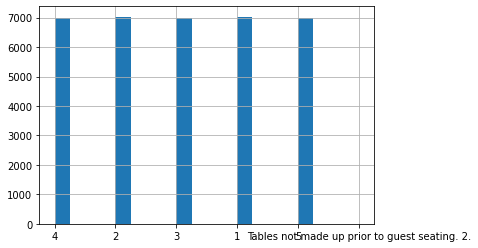

In [ ]:
# checking if all the labels are balanced
train_df.rating.hist(bins=20)

In [ ]:
# splitting into input(x) and output(y) lists
ytrain = [int(re.search("[1-5]",element).group(0)) for element in list(train_df.rating)]
Xtrain = list(train_df.review)

yeval = [int(element) for element in list(eval_df.rating)]
Xeval = list(eval_df.review) 

Xtest = list(test_df.review)


len(Xtrain)

35005

In [ ]:
# remove hyperlinks, punctuations and lemmetize word 
def tokenize_data(dataset):
    final = []
    tokenizer = nltk.tokenize.TreebankWordTokenizer()
    stop_words = set(stopwords.words('english'))
    lemmatizer = nltk.stem.WordNetLemmatizer()
    punct = "~`!@#$%^&*()_-+={[}]|\:;'<,>.?/"
    for i in range(len(dataset)):
       x = tokenizer.tokenize(dataset[i])
       x = ([token.lower() for token in x if token not in stop_words])
       x = " ".join([lemmatizer.lemmatize(token) for token in x]).strip()
       x = "".join([char for char in x if char not in punct])
       final.append(x)
    return final

In [ ]:
# Caling preprocessing function on each input
train_data = tokenize_data(Xtrain)
eval_data = tokenize_data(Xeval)
test_data = tokenize_data(Xtest)

In [ ]:
train_data[0]

'arrived 10pm check painless the downside hotel looking city centre location if nt mind walking want noise city place ideal hotel bar restaurant  decent size gym roof terrace sun loungers the room good size  especially traveling large teenager good sized lounge double sofa bed  kitchen area dining table main bedroom good size double wardrobe safe shower room well sized plenty towel  good supply toiletry  hairdryer fridge come stocked bottle water get started get hotel bar a 5 minute walk take marina metro station access to…'

In [ ]:
def fit_corpus(train_data):
    tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1,2), max_features=10000)
    tfidf.fit(train_data)
    return tfidf

In [ ]:
def transform_data(tfidf, train_data):
    features = tfidf.transform(train_data)
    return pd.DataFrame(features.todense(), columns = tfidf.get_feature_names())

In [ ]:
# Convert sentences to TFIDF vectors
tfidf = fit_corpus(train_data)  #Fitting the vecorizer
train_features = transform_data(tfidf, train_data)  #transforming train data
eval_features = transform_data(tfidf, eval_data)   # transforming eval data
test_feaures = transform_data(tfidf,test_data)     # transforming test data

In [ ]:
train_labels = ytrain
eval_labels = yeval

**Naive** **Bayes**

In [ ]:
# Building pipeline for Naive Bayes model
nb_model = Pipeline([
        ('nbc_classification', MultinomialNB())
    ])

In [ ]:
# calculating training score after fitting the model
nb_model.fit(train_features, train_labels)
train_score = nb_model.score(train_features, train_labels)
print("train score =>", train_score)

train score => 0.7802313955149265


In [ ]:
# Calculating evalaution score
eval_score = nb_model.score(eval_features, eval_labels)
print("eval score =>", eval_score)

eval score => 0.7230297372983064


In [ ]:
scores = cross_validate(nb_model, train_features, train_labels, scoring=make_scorer(accuracy_score),
                        cv=5, return_train_score=True)

In [ ]:
print("cross validate score => ", scores['test_score'].mean())

cross validate score =>  0.725239251535495


**Testing/Prediction**

In [ ]:
# predicting features
pred = nb_model.predict(test_feaures)

In [ ]:
pred

array([1, 5, 1, ..., 4, 2, 1])

In [ ]:
# inserting predictions and test input in to dataframe
data = {'review':Xtest,'predicted_rating':pred}
df_test = pd.DataFrame(data)
df_test.head()

,review,predicted_rating
0,Not at all what expected. Our mountain view ...,1
1,Good location as we needed to head to Reims th...,5
2,Me and my son just returned from Broadmoor Mia...,1
3,The place was filthy and full of stoned backpa...,2
4,The hotel itself is really nice and modern whi...,4
